# Cigna
# Meijer - Root Causes with no transcriptions
# BMO - Root Causes with some transcriptions

In [1]:
!pip install --proxy=http://proxycachest.hewitt.com:3228 xgboost

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [60]:
from xgboost import XGBClassifier

In [61]:
import boto3
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [62]:
import os
import sys
import warnings
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import pickle
import seaborn as sns

In [63]:
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet

In [64]:
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import type_of_target
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

## Retrieve BMO transcripts from s3 bucket

In [65]:
def get_transcripts(s3_bucket=None,prefix_source=None,return_json=False):
    
    s3 = boto3.resource('s3')
    my_bucket_source = s3.Bucket(s3_bucket)
    
    df_json = pd.DataFrame()
    df_metadata = pd.DataFrame()
    for bucket_object in my_bucket_source.objects.filter(Prefix=prefix_source):
        if str(bucket_object.key).endswith('.json'):
            path = 's3://{}/{}'.format(bucket_object.bucket_name, bucket_object.key)
            data = pd.read_json(path, lines=True)
            df_json = pd.concat([df_json, data], axis=0)
        elif str(bucket_object.key).endswith('.csv'):
            path = 's3://{}/{}'.format(bucket_object.bucket_name, bucket_object.key)
            df_metadata = pd.read_csv(path)
            
    df_json['transcripts'] = df_json['results'].apply(lambda x: x['transcripts'][0]['transcript'])
    df_json = df_json.reset_index(drop=True)
    
    if return_json:
        return df_json, df_metadata
    
    df_json = df_json.drop(columns=['status', 'accountId'])
    df_json.jobName = df_json.jobName.apply(lambda x: x.split('_')[1])
    
    if df_metadata.empty:
        df_metadata = None
        print("There is no metadata available with the jsons")
        
    return df_json, df_metadata

In [136]:
df_trans, df_bmo_meta = get_transcripts(s3_bucket='adl-core-sagemaker-studio', prefix_source='calldata/bmo/2021-06-23',return_json=True)

In [138]:
df_trans_bmo = df_trans.copy()

In [139]:
df_trans_bmo.head(1)

,jobName,accountId,results,status,transcripts
0,356802698_1_6856745667150298234_1_30.wav2021-0...,660999144548,{'transcripts': [{'transcript': 'Thank you for...,COMPLETED,Thank you for calling this is how may I help y...


In [140]:
df_trans_bmo = pd.concat([pd.DataFrame([x[:3] for x in df_trans_bmo.jobName.str.split('_').tolist()],
                                 columns = ['uuid','seg_num','seg_id']), df_trans_bmo], axis=1)

In [141]:
df_trans_bmo.head(1)

,uuid,seg_num,seg_id,jobName,accountId,results,status,transcripts
0,356802698,1,6856745667150298234,356802698_1_6856745667150298234_1_30.wav2021-0...,660999144548,{'transcripts': [{'transcript': 'Thank you for...,COMPLETED,Thank you for calling this is how may I help y...


In [146]:
df_trans_bmo.transcripts.replace("",np.nan,inplace=True)

In [72]:
trans_null = df_trans_bmo[df_trans_bmo.transcripts.isnull()]
df_trans_bmo.dropna(subset=['transcripts'],inplace=True)

In [147]:
df_trans_bmo = df_trans_bmo.merge((df_trans_bmo.groupby('uuid',as_index=False)[['seg_num','transcripts']]
                                   .count().rename(columns={'seg_num':'Segment_Counts','transcripts':'Trans_Counts'})),
                                  on = "uuid", copy=False)

In [149]:
unknown_calls = df_trans_bmo.query("uuid == 'Call1'")
df_trans_bmo.drop(unknown_calls.index.to_list(), axis=0, inplace=True)

In [150]:
df_trans_bmo = df_trans_bmo.astype({'uuid':int,'seg_num':int,"seg_id":int,'Segment_Counts':int,'Trans_Counts':int})

In [76]:
all(df_trans_bmo.Segment_Counts == df_trans_bmo.Trans_Counts)

True

In [77]:
one_segments_df = df_trans_bmo.query("Segment_Counts == 1")
multi_segments_df = df_trans_bmo.query("Segment_Counts > 1")

In [78]:
print(f"Total No. of BMO Transcripts originally retrieved: {len(df_trans)}")
print(f"Total No. of BMO Transripts available after cleaning: {len(df_trans_bmo)}")
print(f"Total no. of unique calls: {df_trans_bmo.uuid.nunique()}")
print("------------------------------------------------------\n")
print("Exclusions from df:")
print(f"Total no. of rows with no transcripts (a row does not necessary imply a unique call): {len(trans_null)}")
print(f"Total no. of transcripts from unknown calls (uuid - 'Call1') : {len(unknown_calls)}")
print("------------------------------------------------------------------------------------------\n")
print("Drill Down into cleaned df:")
print(f"Total no. of trancripts Single segment calls: {len(one_segments_df)}")
print(f"Total no. of trancripts Multiple segment calls: {len(multi_segments_df)}")
print(f"Total no. of unique calls with multiple segments: {multi_segments_df.uuid.nunique()}")
print(f"The segments in multi-segment calls ranges from {multi_segments_df.Segment_Counts.min()} to {multi_segments_df.Segment_Counts.max()}")

Total No. of BMO Transcripts originally retrieved: 217
Total No. of BMO Transripts available after cleaning: 183
Total no. of unique calls: 106
------------------------------------------------------

Exclusions from df:
Total no. of rows with no transcripts (a row does not necessary imply a unique call): 4
Total no. of transcripts from unknown calls (uuid - 'Call1') : 30
------------------------------------------------------------------------------------------

Drill Down into cleaned df:
Total no. of trancripts Single segment calls: 83
Total no. of trancripts Multiple segment calls: 100
Total no. of unique calls with multiple segments: 23
The segments in multi-segment calls ranges from 2 to 14


# Create Table
### Filenames, File Count, Raw Text, Clean text, tf_idf (clean_text)

## Upload Root Cause Table & Merge with transcripts

## UIDS with no available jsons for BMO

In [172]:
df_RC_master = pd.read_csv("../Data/Consolidated_data.csv",encoding = "ISO-8859-1")

In [166]:
df_RC_master.head(1)

,call_unique_id,accessdirect_option_name,accessdirect_exit_option,capis_client_id,queue_domain_code,queue_service,domain_line_of_business_code,cspro_primary_topic,cspro_primary_topic_2,cspro_primary_topic_3,cspro_primary_subtopic,cspro_primary_subtopic_2,cspro_primary_subtopic_3,cspro_call_comment,caller_type_code,call_talk_time,repeat_caller_alert_code,Call Topic,Call Subtopic,Root Cause,Secondary Root Cause,Open Questions,Call Details \n(Be as detail as needed here - having enough detail here will prevent need to relisten to call when reviewing and asked questions),Caller Status \n(status at time of call),"Calling As? (HRBP, Manager, EE)","If HRBP/MGR, how many EE's calling for? (# of EE's)",Is self-service Available? (Y/N),Was self-service attempted prior to call?,"If yes, why didn't self-service work or fulfill need?",Request (SR) required to resolve issue? (Y/N),Why was request (SR) needed?,Was portal resolution offered or callback?,Did CCR/Alight Ops process transaction on behalf of caller? (Y/N),"If yes, did Alight offer to navigate via SS for caller to process transaction?",Self Service Promoted by CCR when appropriate? (Y/N or n/a),Was caller a repeat caller? Called more than once in last 45 days for same topic (Y/N),Volume/# of repeat calls?,"If yes, why did caller have to call repatedly to resolve issue?",CCR correct action taken on call - knowledge only no personal service focus? (Y/N),Did or Will incorrect action potentially drive additional calls? \n(Y/N or n/a),Additional Comments/Call Outs,Open Questions?,Person Internal Id,Agent Call Answer Indicator,Agent Call Duration,AWT,Alternate EE ID,As of Date,Avg Wait Time,Call Abandoned Indicator,Call Answered Indicator,Call Begin Timestamp Gmt Time Zone,Call Duration,Call End Timestamp Gmt Time Zone,Call Handled Time,AHT decimal,Call Hold Time,Call Status,Call Talk Time,Call Unique Id,Call Unique Timestamp Gmt Time Zone,Call Wait Time,Call Work Time,Client Name,Cspro Primary Subtopic,Topics,Cspro Primary Topic,Interaction Topic,Job Title Mgr,Mgmt Level,Begin_Date,Avg Handle Time,HH:MM:SS - AHoT,Topic Subtopic,Time_Diff,Call_Begin_CST,Division-Sector,Calls Received,calls_abandoned,Calls Answered,Avg Interactions per Person,AHT2,Unique person_ID,30 secs,Average Hold time,Initiator Div,Call Client,Calls Answered (copy),Calls Received (copy),Client Name (group),Client ID,Client ID1,Domain Line Of Business Code,Domain Line Of Business Description,Duration,Division Label,Ee Guid,Employee Type,Employment Status,First Name,Gpid,Half Hourly Interval,HRMS EE Lookup ID,Home City,Home Country,Home State,Interaction Sub Topic,Interaction Channel,Is BM,Is HRA,Is HRM,Job Code,Job Function Label,Job Title,Line Of Business,Load Timestamp,Last Name,Leadership Group Level,Load Date,Manager Indicator,Mgmt Level (group),Number of Records,Person Id,Person Id New,Platform Id,Platform Name,Pay Group Label,Domain,Queue,Queue Domain,Queue Domain Code,Queue Is Hrbpo,Queue Location,Queue Service,Queue Service Description,Service Center Location,Service Connect Case Reason Level 1,Service Connect Case Reason Level 2,Service Connect Case Reason Level 3,Source System Code,Sector Label,Split Client,TBA Person Internal ID,Unique person_ID (copy),Work City,Work Country Code,Work Location Code,Work Location Type,Work State External Code,Work Zip Code,Worker Type
0,356802698,NaN,oth_hr_serv,1881,HRBPO,HRBPO,HB,Payroll - Overpayment,Common,NaN,Repayment Discussion,Secure Caller,NaN,EE called in regards to overpayment as she is ...,ACH,756,NaN,Overpayment,Incorrect LOA status entry,Manager processing error/delay/inaction,CCR Knowledge: Lack of CCR Tool Usage (callflows),Repayment options/amounts,caller asked about paying overpayment from nex...,Unpaid Leave,Employee,NaN,N,No SS,NaN,Y,Additional research/explanation,Callback offered,N,NaN,N,Y,2,Case - returning CCR call,N - didn't complete counsel,Y,CCR did not confirm with caller that she recei...,NaN,309230008,True,865,13,300068867,NaN,0:00:13,False,Tru

In [192]:
# df_RC_master - Root Cause Data for bmo

# df_trans_bmo - all jsons available in s3 for bmo

missing_jsons_uuids = df_RC_master[~(df_RC_master['call_unique_id'].isin(df_trans_bmo['uuid'].values))].call_unique_id

In [179]:
len(df_trans_bmo.uuid.unique())

106

In [193]:
len(missing_jsons_uuids)

100

In [196]:
all(missing_jsons_uuids.unique() == missing_jsons_uuids.values)

True

In [197]:
missing_jsons_uuids.to_csv('missing_jsons_uuids_bmo.csv',index=False)

In [86]:
df_RC_master = pd.read_pickle("../Data/pickle_files/master_cleaneddf.pkl")

In [87]:
df_RC_master.head(2)

,Person_Internal_Id,AWT,Call_Begin_Timestamp_Gmt_Time_Zone,Call_End_Timestamp_Gmt_Time_Zone,Cspro_Primary_Subtopic,Cspro_Primary_Topic,Mgmt_Level,Avg_Handle_Time,Average_Hold_time,Duration,Division_Label,Employee_Type,Employment_Status,Home_City,Home_Country,Job_Function_Label,Job_Title,Domain,Queue_Domain,Sector_Label,Work_City,Work_Location_Code,accessdirect_option_name,accessdirect_exit_option,Right_call_unique_id,cspro_primary_topic_2,cspro_primary_subtopic_2,cspro_call_comment,text_clean,Root_Cause
0,309230008,13,2020-08-03 13:15:00,2020-08-03 13:29:00,Repayment Discussion,Payroll - Overpayment,MLH_Professional,00:14:13,96,852,TOP_BMO,0,Active,Mississauga,CAN,Bonus,Associate II-IC Corporate Cards,Payroll,Human Resources Business Process Outsourcing,M3181 - Meadowvale CCC - BMO,Mississauga,CAN-ON,NaN,oth_hr_serv,3.56803e+08,Common,Secure Caller,EE called in regards to overpayment as she is ...,ee called regard overpayment top payment want ...,Manager processing error/delay/inaction
1,494230023,8,2020-08-03 13:24:00,2020-08-03 13:25:00,General Inquiry,Payroll - Policy/Procedures,MLH_Professional,00:01:54,0,104,TOP_BMO,0,Terminated,Noblesville,USA,US_SOC,Senior Associate-IC Retail Banking II,Payroll,Human Resources Business Process Outsourcing,H1168 - Noblesville (350 W.Logan),Noblesville,USA-IN,Time and Absence3,time_absence,3.56804e+08,Common,Secure Caller,VAC payout policy when terminated,vac payout policy terminated,Policy/Process Interpretation


In [88]:
df_RC_master.rename(columns={"text_clean":"cspro_cleaned"},inplace=True)

In [25]:
#df_RC_subset = df_RC_master[['Client Name','Call Unique Id','Right_call_unique_id',
#                             'Root Cause','Call Begin Timestamp Gmt Time Zone','Call End Timestamp Gmt Time Zone']]
#df_RC_subset.head(2)

In [89]:
print(f"Datetime Range for the calls captured in the root cause dataframe: {df_RC_master.Call_Begin_Timestamp_Gmt_Time_Zone.min()} to {df_RC_master.Call_End_Timestamp_Gmt_Time_Zone.max()}")

Datetime Range for the calls captured in the root cause dataframe: 2020-08-03 13:15:00 to 2020-08-31 20:46:00


In [90]:
# Joining only with one segment calls dataframe
merged_df = pd.merge(one_segments_df, df_RC_master, how="inner", left_on="uuid", right_on="Right_call_unique_id")
print(f"Total no. of merged rows: {len(merged_df)}")

Total no. of merged rows: 80


In [91]:
merged_df.head(2)

,uuid,seg_num,seg_id,jobName,accountId,results,status,transcripts,Segment_Counts,Trans_Counts,Person_Internal_Id,AWT,Call_Begin_Timestamp_Gmt_Time_Zone,Call_End_Timestamp_Gmt_Time_Zone,Cspro_Primary_Subtopic,Cspro_Primary_Topic,Mgmt_Level,Avg_Handle_Time,Average_Hold_time,Duration,Division_Label,Employee_Type,Employment_Status,Home_City,Home_Country,Job_Function_Label,Job_Title,Domain,Queue_Domain,Sector_Label,Work_City,Work_Location_Code,accessdirect_option_name,accessdirect_exit_option,Right_call_unique_id,cspro_primary_topic_2,cspro_primary_subtopic_2,cspro_call_comment,cspro_cleaned,Root_Cause
0,356802698,1,6856745667150298234,356802698_1_6856745667150298234_1_30.wav2021-0...,660999144548,{'transcripts': [{'transcript': 'Thank you for...,COMPLETED,Thank you for calling this is how may I help y...,1,1,309230008,13,2020-08-03 13:15:00,2020-08-03 13:29:00,Repayment Discussion,Payroll - Overpayment,MLH_Professional,00:14:13,96,852,TOP_BMO,0,Active,Mississauga,CAN,Bonus,Associate II-IC Corporate Cards,Payroll,Human Resources Business Process Outsourcing,M3181 - Meadowvale CCC - BMO,Mississauga,CAN-ON,NaN,oth_hr_serv,3.56803e+08,Common,Secure Caller,EE called in regards to overpayment as she is ...,ee called regard overpayment top payment want ...,Manager processing error/delay/inaction
1,356804330,1,6856747973547736204,356804330_1_6856747973547736204_1_30.wav2021-0...,660999144548,{'transcripts': [{'transcript': 'Thank you for...,COMPLETED,"Thank you for calling Bmo, my name is billy, h...",1,1,494230023,8,2020-08-03 13:24:00,2020-08-03 13:25:00,General Inquiry,Payroll - Policy/Procedures,MLH_Professional,00:01:54,0,104,TOP_BMO,0,Terminated,Noblesville,USA,US_SOC,Senior Associate-IC Retail Banking II,Payroll,Human Resources Business Process Outsourcing,H1168 - Noblesville (350 W.Logan),Noblesville,USA-IN,Time and Absence3,time_absence,3.56804e+08,Common,Secure Caller,VAC payout policy when terminated,vac payout policy terminated,Policy/Process Interpretation


**Question**: Why does the data merge when the *date ranges from the root cause table* does not match with the *date from the transcripts*?

## Preparing Dataset For Modelling

In [92]:
# Define cat & numeric columns list
continous_cols = ['AWT', 'Average_Hold_time', 'Duration']

cat_cols = ['Cspro_Primary_Subtopic', 
        'Cspro_Primary_Topic', 
        'Mgmt_Level', 
        'Division_Label', 
        'Employee_Type',
        'Employment_Status', 
        'Home_City', 
        'Home_Country', 
        'Job_Function_Label',
        'Job_Title', 'Domain', 
        'Queue_Domain', 
        'Sector_Label', 
        'Work_City',
        'Work_Location_Code', 
        'accessdirect_option_name',
        'accessdirect_exit_option', 
        'cspro_primary_topic_2',
        'cspro_primary_subtopic_2',
        'Root_Cause']

In [93]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

#Usage: df1['text_clean'] = df1.cspro_call_comment.apply(lambda x: clean(x))
def clean(doc):
    stop_free = " ".join(i for i in str(doc).lower().split() if i not in stop)
    punc_free = "".join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


def encode_data(df_master):
    """This should include root cause as a column to label encode it as well"""
    df_master[continous_cols] = df_master[continous_cols].astype(int)
    df_master[cat_cols] = df_master[cat_cols].apply(LabelEncoder().fit_transform)
    return df_master


def split_for_training(cleanedtext_series, df_master):
    """Requires cleaned transcription as a series and a root cause df along with all cc related numeric/cat columns
    
    Returns:
    Xtrain, Xtest: Cleaned Transcripts (not label encoded)
    y_train, y_test: Root cause labels (not label encoded)
    
    df_master_train, df_master_test: Label encoded master df including root cause (& excludes transcript)
    """
    X_train, X_test, y_train, y_test = train_test_split(cleanedtext_series, 
                                                    df_master.Root_Cause, 
                                                    test_size=0.1, 
                                                    random_state=100)

    print("X_train dataset ___________ {}".format(X_train.shape))
    print("y_train dataset ___________ {}".format(y_train.shape))
    print("X_test dataset ____________ {}".format(X_test.shape))
    print("y_test dataset ____________ {}".format(y_test.shape))

    X_train_index = X_train.index.tolist()
    X_test_index = X_test.index.tolist()

    df_master_train = df_master.iloc[X_train_index,:].reset_index(drop=True)
    df_master_test = df_master.iloc[X_test_index,:].reset_index(drop=True)

    return  X_train, X_test, y_train, y_test, df_master_train, df_master_test


def tfidf_vectorize(X_train, X_test):
    """Accepts the cleaned text as a numpy array"""
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test

def concat_tfidf_to_df(df, X, if_only_tfidf=False):
    
    if if_only_tfidf:
        df = pd.concat([pd.DataFrame(X.toarray()), df.Root_Cause], axis=1)
    else:
        df = pd.concat([df.iloc[:,:-1], pd.DataFrame(X.toarray()), 
                                 df.iloc[:,-1]], axis=1)
    print(f"Data dimensions of {df.shape[0]} rows and {df.shape[1]} features........................")
    return df


In [94]:
merged_df['text_clean'] = merged_df.transcripts.apply(lambda x: clean(x))

In [115]:
merged_df.text_clean = merged_df.text_clean + merged_df.cspro_cleaned

In [116]:
#modeling columns used:
df_extra = pd.read_pickle('../Data/pickle_files/LE_df_without_comments.pkl')
actual_model_columns = df_extra.columns.to_list()

In [117]:
df_without_trans = merged_df.copy()
df_without_trans = df_without_trans[actual_model_columns]

In [118]:
df_without_trans = encode_data(df_without_trans)

In [119]:
df_without_trans.head(1)

,AWT,Cspro_Primary_Subtopic,Cspro_Primary_Topic,Mgmt_Level,Average_Hold_time,Duration,Division_Label,Employee_Type,Employment_Status,Home_City,Home_Country,Job_Function_Label,Job_Title,Domain,Queue_Domain,Sector_Label,Work_City,Work_Location_Code,accessdirect_option_name,accessdirect_exit_option,cspro_primary_topic_2,cspro_primary_subtopic_2,Root_Cause
0,13,13,3,1,96,852,0,0,0,19,0,0,1,1,1,47,17,4,29,9,0,4,5


In [120]:
X_train, X_test, y_train, y_test, df_train, df_test = split_for_training(merged_df.text_clean, df_without_trans)

X_train dataset ___________ (72,)
y_train dataset ___________ (72,)
X_test dataset ____________ (8,)
y_test dataset ____________ (8,)


In [121]:
X_train, X_test = tfidf_vectorize(X_train, X_test)

In [123]:
df_train_tfidf = concat_tfidf_to_df(df_train, X_train)
df_test_tf_idf = concat_tfidf_to_df(df_test, X_test)

Data dimensions of 72 rows and 2481 features........................
Data dimensions of 8 rows and 2481 features........................


In [125]:
df_train_tf_idf_only = concat_tfidf_to_df(df_train, X_train, if_only_tfidf=True)
df_test_tf_idf_only = concat_tfidf_to_df(df_test, X_test, if_only_tfidf=True)

Data dimensions of 72 rows and 2459 features........................
Data dimensions of 8 rows and 2459 features........................


# Model
### Count: 0 No modelling
### Count: 1 Yes for modelling
### Count: > 1 concat transcripts? - analysis in new notebook

# use current modelling effort

## Modelling broken down into two parts
### 1. All the data
### 2. Transcriptions, CS_PRO_Notes, Root Cause

In [126]:
def print_dataframe(df):
    
    """
    Print or display the entire dataframe 
    
    Parameters
    ---------- 
    df: Dataframe
   
    Returns
    -------
    df: None
    
    """
    
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
        
    display(df)
    
    return None

In [127]:
def load_and_test_models(df):
    
    # retrieve numpy array
    
    data = df.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]

    # label encode the target variable to have the classes 0, 1, 2, etc.
    # This is already done for all cat features on in earlier statements.
    y = LabelEncoder().fit_transform(y)
    
    print('\nType of target _________ {}'.format(type_of_target(y)))
    


    models = [RandomForestClassifier(n_estimators=1000, max_depth=3, class_weight='balanced', random_state=0),
              LinearSVC(class_weight='balanced', random_state=0),
              MultinomialNB(),
              LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=0),
             XGBClassifier()]
  
    # define evaluation procedure
    CV = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100)
    #CV = 5

    #index=range(CV * len(models))
    cv_df = pd.DataFrame()
   
    entries = []

    for model in models:
        
        model_name = model.__class__.__name__
        
        # evaluate model
        accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV, n_jobs=-1)
            
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))

    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
    # summarize performance
    cv_df_mean_accuracy = pd.DataFrame(cv_df.groupby(['model_name']).agg({'accuracy': ['mean', 'std']}).reset_index())
    cv_df_mean_accuracy.columns = ['_'.join(col) for col in cv_df_mean_accuracy.columns]
    print_dataframe(cv_df_mean_accuracy)
    print('\n')

    # Plot model performance
    
    plt.figure(figsize=(10,6)) 

    sns.boxplot(x='model_name', y='accuracy', data=cv_df)

    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    
    return cv_df

All features including TF-IDF _________________________

Type of target _________ multiclass


,model_name_,accuracy_mean,accuracy_std
0,LinearSVC,0.119365,0.074459
1,LogisticRegression,0.138730,0.067891
2,MultinomialNB,0.318730,0.059079
3,RandomForestClassifier,0.463810,0.109032
4,XGBClassifier,0.476190,0.110671


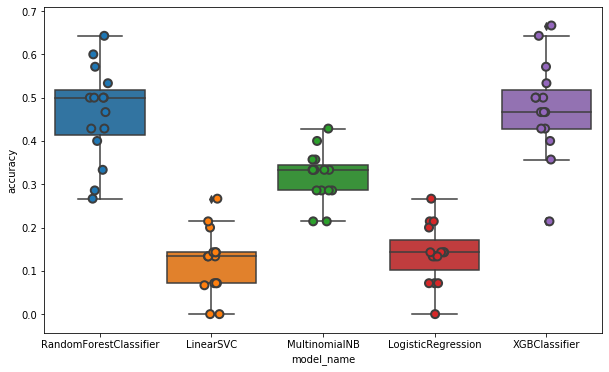

In [128]:
print('All features including TF-IDF _________________________')
cv_df = load_and_test_models(df_train_tfidf)

In [129]:
med_df1 = cv_df.groupby('model_name').agg({'accuracy':np.median})
med_df1

,accuracy
model_name,
LinearSVC,0.133333
LogisticRegression,0.142857
MultinomialNB,0.333333
RandomForestClassifier,0.500000
XGBClassifier,0.466667


In [130]:
med_df1.accuracy.mean()

0.31523809523809526

TF-IDF features only ________________________________

Type of target _________ multiclass


,model_name_,accuracy_mean,accuracy_std
0,LinearSVC,0.535873,0.107024
1,LogisticRegression,0.526984,0.078425
2,MultinomialNB,0.294921,0.075238
3,RandomForestClassifier,0.421270,0.089121
4,XGBClassifier,0.400635,0.147782


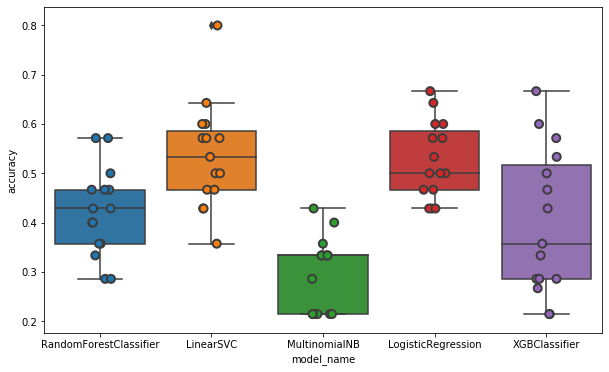

In [131]:
print('TF-IDF features only ________________________________')
cv_df2 = load_and_test_models(df_train_tf_idf_only)

In [132]:
med_df2 = cv_df2.groupby('model_name').agg({'accuracy':np.median})
med_df2

,accuracy
model_name,
LinearSVC,0.533333
LogisticRegression,0.500000
MultinomialNB,0.333333
RandomForestClassifier,0.428571
XGBClassifier,0.357143


In [133]:
med_df2.accuracy.mean()

0.43047619047619046

# AWS AutoML

In [134]:
!pip install --proxy=http://proxycachest.hewitt.com:3228 gensim

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 23.9 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 771 kB/s  eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
